The purpose of this notebook, is to try clustering the different community areas of chicago based on different factors:'Crime Rate', 'Amenity Rate' and 'SEH Rate' (SEH standing for Socio Economic Human).

First we import all the libs we will need for this notebook:

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from geopy.geocoders import Nominatim
import folium
import json
import re
import itertools
import threading
import time
import sys
import requests
from folium.plugins import MarkerCluster
import ipywidgets
from pandas import json_normalize
import math
import sklearn
from sklearn.cluster import KMeans
from mpl_toolkits import mplot3d


print('Libraries imported')

Libraries imported


We specify the path to the csv file used for 'Crime Rate' (as it is in Jupyter Notebook, we need to specify that it is an os path)

In [2]:
path=os.path.join('c:' + os.sep, 'Users', 'Valentin', 'Downloads','CHI_crimes_2018.csv')
df_crime = pd.read_csv(path)

In [3]:
df_crime

ID Case Number                    Date                  Block  \
0       11646166    JC213529  09/01/2018 12:01:00 AM  082XX S INGLESIDE AVE   
1       11645648    JC212959  01/01/2018 08:00:00 AM    024XX N MONITOR AVE   
2       11645959    JC211511  12/20/2018 04:00:00 PM     045XX N ALBANY AVE   
3       11645557    JC212685  04/01/2018 12:01:00 AM     080XX S VERNON AVE   
4       11646293    JC213749  12/20/2018 03:00:00 PM   023XX N LOCKWOOD AVE   
...          ...         ...                     ...                    ...   
268277  11233930    JB156402  02/18/2018 02:00:00 AM        017XX W 80TH ST   
268278  11494360    JB498928  07/07/2018 04:00:00 PM       059XX S KNOX AVE   
268279  12164451    JD365861  09/11/2018 09:00:00 PM    049XX S WOLCOTT AVE   
268280  12267823    JE110842  01/01/2018 12:00:00 AM   092XX S MANISTEE AVE   
268281  12228583    JD435329  07/17/2018 12:01:00 AM  045XX S WASHTENAW AVE   

        IUCR                Primary Type  \
0       0810                       THEFT   
1       1153          DECEPTIVE PRACTICE   
2       2820               OTHER OFFENSE   
3       1153          DECEPTIVE PRACTICE   
4       1154          DECEPTIVE PRACTICE   
...      ...                         ...   
268277  0263     CRIMINAL SEXUAL ASSAULT   
268278  1130          DECEPTIVE PRACTICE   
268279  1582  OFFENSE INVOLVING CHILDREN   
268280  1585                 SEX OFFENSE   
268281  1751  OFFENSE INVOLVING CHILDREN   

                                    Description Location Description  Arrest  \
0                                     OVER $500            RESIDENCE   False   
1           FINANCIAL IDENTITY THEFT OVER $ 300            RESIDENCE   False   
2                              TELEPHONE THREAT            RESIDENCE   False   
3           FINANCIAL IDENTITY THEFT OVER $ 300            RESIDENCE   False   
4       FINANCIAL IDENTITY THEFT $300 AND UNDER            APARTMENT   False   
...                                         ...                  ...     ...   
268277  AGGRAVATED - KNIFE / CUTTING INSTRUMENT            RESIDENCE   False   
268278                 FRAUD OR CONFIDENCE GAME   RESIDENCE - GARAGE   False   
268279                        CHILD PORNOGRAPHY               STREET    True   
268280                                    OTHER            RESIDENCE   False   
268281   CRIMINAL SEXUAL ABUSE BY FAMILY MEMBER            APARTMENT    True   

        Domestic  ...  Ward  Community Area  FBI Code  X Coordinate  \
0           True  ...   8.0              44        06           NaN   
1          False  ...  30.0              19        11           NaN   
2          False  ...  33.0              14       08A           NaN   
3          False  ...   6.0              44        11           NaN   
4          False  ...  36.0              19        11           NaN   
...          ...  ...   ...             ...       ...           ...   
268277     False  ...  21.0              71        02     1166029.0   
268278     False  ...  13.0              64        11     1146395.0   
268279     False  ...  15.0              61        17     1164519.0   
268280      True  ...   7.0              48        17           NaN   
268281      True  ...  15.0              58        17     1159128.0   

       Y Coordinate  Year              Updated On   Latitude  Longitude  \
0               NaN  2018  04/06/2019 04:04:43 PM        NaN        NaN   
1               NaN  2018  04/06/2019 04:04:43 PM        NaN        NaN   
2               NaN  2018  04/06/2019 04:04:43 PM        NaN        NaN   
3               NaN  2018  04/06/2019 04:04:43 PM        NaN        NaN   
4               NaN  2018  04/06/2019 04:04:43 PM        NaN        NaN   
...             ...   ...                     ...        ...        ...   
268277    1851644.0  2018  01/12/2021 03:51:50 PM  41.748489 -87.667186   
268278    1864489.0  2018  01/12/2021 03:51:50 PM  41.784132 -87.738808   
268279    1871946.0  2018  01/13/2021 03:48:22 

We can see that the number of data is consequent, over 5 milion and as we will use a small amount of the data for this analysis, we can drop the columns we won't use

In [4]:
df_crime.drop(columns=['Block','Beat','District','Ward','FBI Code', 'X Coordinate', 'Y Coordinate','Updated On', 'Year','ID','IUCR'], inplace=True)
df_crime.dropna(subset=['Location'], inplace=True)

Converting the Date in a Date format, so we can use the date in a later analysis

In [5]:
df_crime.Date=pd.to_datetime(df_crime.Date)

In [6]:
df_crime.columns

Index(['Case Number', 'Date', 'Primary Type', 'Description',
       'Location Description', 'Arrest', 'Domestic', 'Community Area',
       'Latitude', 'Longitude', 'Location'],
      dtype='object')

Then, we will focus on the Primary Type column, and count the occurence of each type of crime. We will display the data using seaborn

In [7]:
Type_crime=df_crime['Primary Type'].value_counts().to_frame().reset_index().rename(columns={'index':'Primary Type','Primary Type':'Occurence'})

In [8]:
Type_crime

Primary Type  Occurence
0                               THEFT      64023
1                             BATTERY      49714
2                     CRIMINAL DAMAGE      27700
3                             ASSAULT      20342
4                  DECEPTIVE PRACTICE      17859
5                       OTHER OFFENSE      16952
6                           NARCOTICS      12797
7                            BURGLARY      11690
8                 MOTOR VEHICLE THEFT       9935
9                             ROBBERY       9676
10                  CRIMINAL TRESPASS       6881
11                  WEAPONS VIOLATION       5444
12         OFFENSE INVOLVING CHILDREN       2153
13                CRIM SEXUAL ASSAULT       1376
14             PUBLIC PEACE VIOLATION       1364
15   INTERFERENCE WITH PUBLIC OFFICER       1305
16                        SEX OFFENSE       1050
17                       PROSTITUTION        717
18                           HOMICIDE        600
19                              ARSON        373
20               LIQUOR LAW VIOLATION        265
21                           GAMBLING        201
22                           STALKING        199
23            CRIMINAL SEXUAL ASSAULT        188
24                         KIDNAPPING        172
25                       INTIMIDATION        167
26  CONCEALED CARRY LICENSE VIOLATION        148
27                          OBSCENITY         84
28                       NON-CRIMINAL         36
29                   PUBLIC INDECENCY         14
30                  HUMAN TRAFFICKING         12
31   NON-CRIMINAL (SUBJECT SPECIFIED)          3
32           OTHER NARCOTIC VIOLATION          1

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'THEFT'),
  Text(1, 0, 'BATTERY'),
  Text(2, 0, 'CRIMINAL DAMAGE'),
  Text(3, 0, 'ASSAULT'),
  Text(4, 0, 'DECEPTIVE PRACTICE'),
  Text(5, 0, 'OTHER OFFENSE'),
  Text(6, 0, 'NARCOTICS'),
  Text(7, 0, 'BURGLARY'),
  Text(8, 0, 'MOTOR VEHICLE THEFT'),
  Text(9, 0, 'ROBBERY')])

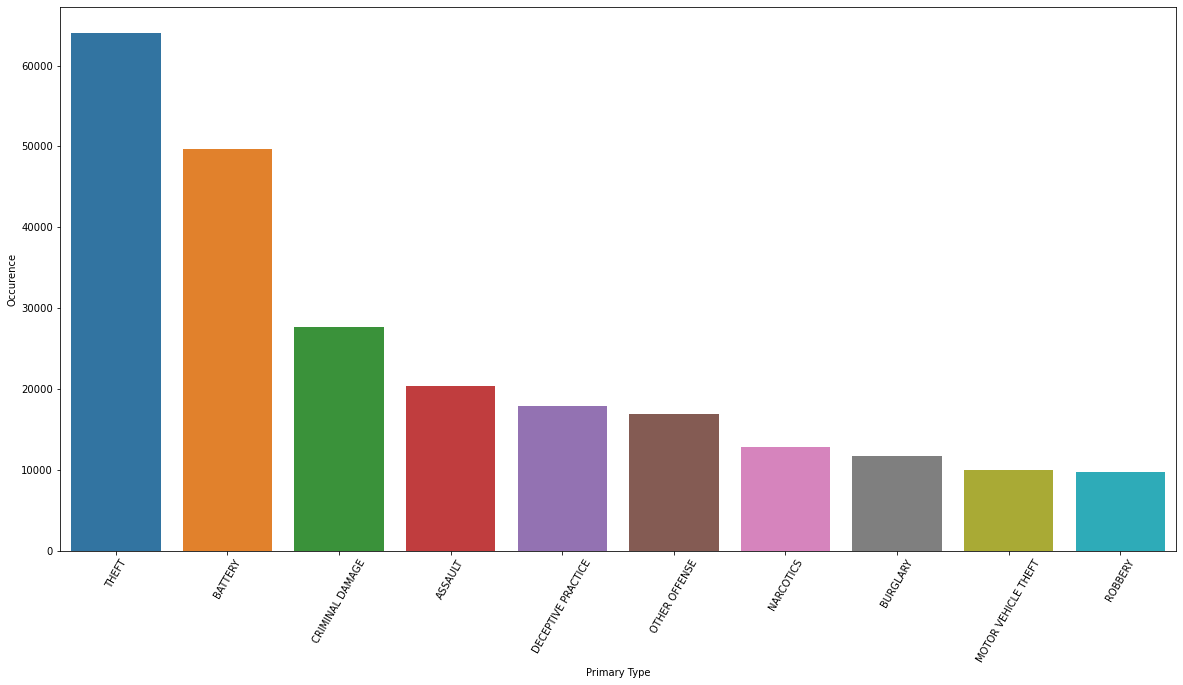

In [9]:
plt.figure(figsize=(20, 10))
sns.barplot(data=Type_crime.head(10),x='Primary Type', y='Occurence')
plt.xticks(rotation=60)

The objective now is to display on a choropleth map the crime rate per community area.
First of all, we will assign a name instead of a number to the community area row.

In [10]:
#reset the index to use the df
df_crime.reset_index(drop=True,inplace=True)
#We get a page with the name of the community area, there are some valuable information here such as the density, and the name
wikiurl = "https://en.wikipedia.org/wiki/Community_areas_in_Chicago"
dfs = pd.read_html(wikiurl)
df_ca=dfs[0]
#droping the columns we won't use
df_ca.drop(df_ca.columns[2],axis=1,inplace=True)
df_ca.drop(df_ca.columns[2],axis=1,inplace=True)
df_ca.drop(df_ca.columns[3],axis=1,inplace=True)
df_ca.set_index('Number[8]')
#Replacing O'hare by Ohare, which will make the analysis MUCH easier
df_ca['Name[8]'][75]='Ohare'
df_ca

<ipython-input-10-34bee5819ebe>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca['Name[8]'][75]='Ohare'


Number[8]          Name[8]  Area (km2)  2017density (/km2)
0         01      Rogers Park        4.77            11554.11
1         02       West Ridge        9.14             8336.20
2         03           Uptown        6.01             9648.06
3         04   Lincoln Square        6.63             6291.50
4         05     North Center        5.31             6740.59
..       ...              ...         ...                 ...
73        74  Mount Greenwood        7.02             2746.45
74        75      Morgan Park        8.55             2620.11
75        76            Ohare       34.55              358.23
76        77        Edgewater        4.51            12418.51
77     Total          Chicago      588.81             4623.89

[78 rows x 4 columns]

As there are a lot of data and the runtime is mostlikely to be long, We want to track the progress of our for loop
To do so, we display a progress % (sys.stdout.write combined with sys.stdout.flush allows us to print only one 
loading line, the "\r" is a carriage return, and allow)
Update: doing so prints too much value per second, and jupyter notebook output rate is overwhelmed. I have removed this piece of code

In [11]:
df_crime['Community Name']=''

for row in df_crime.index:
    df_crime['Community Name'][row]=df_ca['Name[8]'][int(df_crime['Community Area'][row])-1]
    
#it takes about 5 minutes to run

<ipython-input-11-b7146094f7a1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_crime['Community Name'][row]=df_ca['Name[8]'][int(df_crime['Community Area'][row])-1]


As we can see here, a warning message appears because a value is added to the dataframe with one already existing. The correct method should be to append an entire list as a column

Now the idea is to groupby community area, and to have for each community area, the percent of crime per ca
To do so we need to: 
- Preprocess the data and drop every columns not needed to clarify the dataframe
- One hot encode the primary type 
- Group By Community Area 
- Count each time a value apppears

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Austin'),
  Text(1, 0, 'Near North Side'),
  Text(2, 0, '(The) Loop[11]'),
  Text(3, 0, 'Near West Side'),
  Text(4, 0, 'North Lawndale'),
  Text(5, 0, 'South Shore'),
  Text(6, 0, 'Humboldt Park'),
  Text(7, 0, 'Auburn Gresham'),
  Text(8, 0, 'West Town'),
  Text(9, 0, 'West Englewood')])

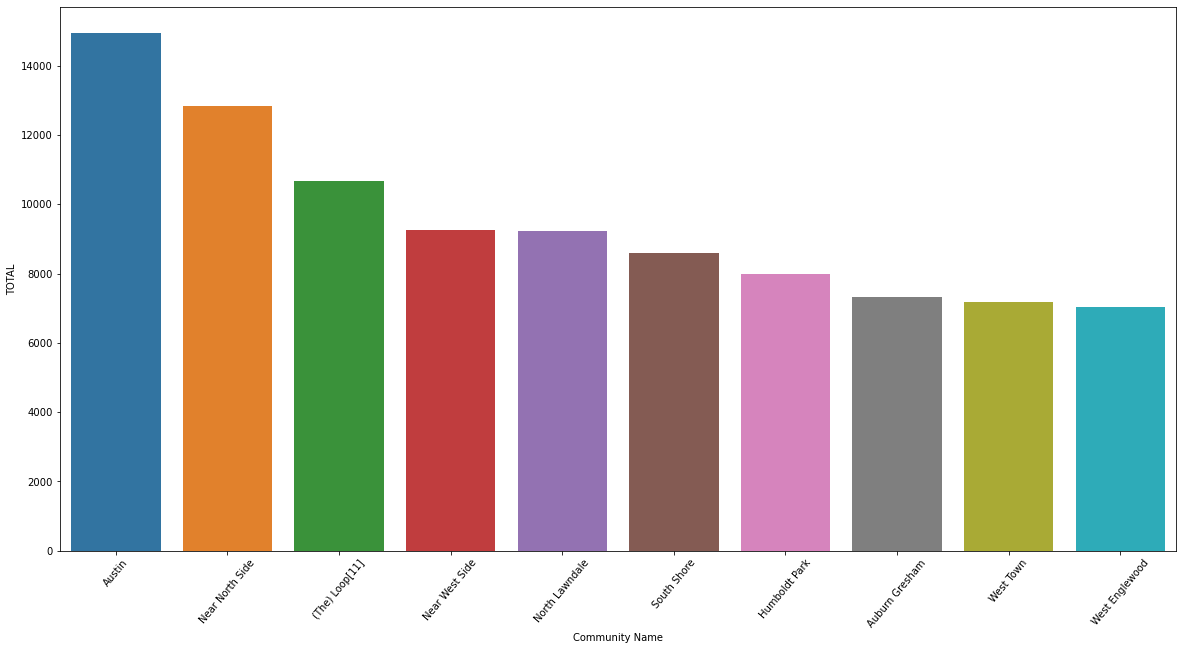

In [12]:
df_type_rate=df_crime.drop(df_crime[['Case Number','Date', 'Description', 'Location Description','Latitude','Longitude','Location Description','Community Area','Arrest','Domestic']],axis=1)
one_hot=pd.get_dummies(df_type_rate['Primary Type'])
df_type_rate.drop(columns='Primary Type',inplace=True)
oh_df_rate=df_type_rate.join(one_hot)
oh_analyze=oh_df_rate.groupby(by='Community Name').sum()
oh_analyze['TOTAL'] = oh_analyze.sum(axis=1)
oh_analyze.sort_values(by="TOTAL", ascending=False, inplace=True)
plt.figure(figsize=(20, 10))
sns.barplot(x=oh_analyze.head(10).index, y=oh_analyze.head(10)['TOTAL'])
plt.xticks(rotation=50)

We can see where most crimes are commited. Now let's display our data in percent

In [13]:
percan=oh_analyze
for column in oh_analyze.columns:
    percan[column]= round(oh_analyze[column]/oh_analyze[column].sum()*100,2)
percan

ARSON  ASSAULT  BATTERY  BURGLARY  \
Community Name                                       
Austin           10.19     6.02     6.79      4.23   
Near North Side   1.07     2.71     3.15      1.81   
(The) Loop[11]    0.80     2.34     2.07      0.63   
Near West Side    1.88     3.22     2.57      2.40   
North Lawndale    4.56     3.36     3.88      2.54   
...                ...      ...      ...       ...   
Montclare         0.00     0.23     0.25      0.37   
Mount Greenwood   0.00     0.19     0.15      0.21   
Forest Glen       0.00     0.12     0.08      0.45   
Burnside          0.00     0.19     0.13      0.15   
Edison Park       0.27     0.08     0.13      0.10   

                 CONCEALED CARRY LICENSE VIOLATION  CRIM SEXUAL ASSAULT  \
Community Name                                                            
Austin                                        1.35                 7.56   
Near North Side                               0.68                 5.31   
(The) Loop[11]                                0.68                 2.83   
Near West Side                                2.03                 4.00   
North Lawndale                                7.43                 3.27   
...                                            ...                  ...   
Montclare                                     0.00                 0.15   
Mount Greenwood                               0.00                 0.22   
Forest Glen                                   0.00                 0.15   
Burnside                                      0.00                 0.15   
Edison Park                                   0.00                 0.00   

                 CRIMINAL DAMAGE  CRIMINAL SEXUAL ASSAULT  CRIMINAL TRESPASS  \
Community Name                                                                 
Austin                      5.10                     5.85               4.53   
Near North Side             2.18                     6.38               5.14   
(The) Loop[11]              1.68                     3.19               4.23   
Near West Side              2.90                     3.19               4.10   
North Lawndale              3.13                     2.13               3.65   
...                          ...                      ...                ...   
Montclare                   0.26                     0.53               0.16   
Mount Greenwood             0.26                     0.00               0.48   
Forest Glen                 0.16                     1.06               0.36   
Burnside                    0.18                     0.00               0.07   
Edison Park                 0.12                     0.00               0.16   

                 DECEPTIVE PRACTICE  ...  OTHER OFFENSE  PROSTITUTION  \
Community Name                       ...                                
Austin                         3.84  ...           6.24         29.29   
Near North Side               10.97  ...           2.27          0.00   
(The) Loop[11]                 9.15  ...           1.61          0.14   
Near West Side                 4.54  ...           2.58          0.14   
North Lawndale                 1.47  ...           2.89          3.07   
...                             ...  ...            ...           ...   
Montclare                      0.24  ...           0.24          0.00   
Mount Greenwood                0.36  ...           0.27          0.00   
Forest Glen                    0.35  ...           0.18          0.00   
Burnside                       0.07  ...           0.15          0.00   
Edison Park                    0.16  ...           0.12          0.00   

                 PUBLIC INDECENCY  PUBLIC PEACE VIOLATION  ROBBERY  \
Community Name                                                       
Austin                       0.00                    8.36     8.04   
Near North Side              7.14                    4.11     3.96   
(The) Loop[11]              14.29                    5.21     3.28 

For each type of crime we have the percentage of occurence depending on the Community Area.
For instance let's try to see which community area has the highest rate of Assault

In [14]:
percan.loc[percan['ASSAULT']==percan['ASSAULT'].max()]

ARSON  ASSAULT  BATTERY  BURGLARY  \
Community Name                                      
Austin          10.19     6.02     6.79      4.23   

                CONCEALED CARRY LICENSE VIOLATION  CRIM SEXUAL ASSAULT  \
Community Name                                                           
Austin                                       1.35                 7.56   

                CRIMINAL DAMAGE  CRIMINAL SEXUAL ASSAULT  CRIMINAL TRESPASS  \
Community Name                                                                
Austin                      5.1                     5.85               4.53   

                DECEPTIVE PRACTICE  ...  OTHER OFFENSE  PROSTITUTION  \
Community Name                      ...                                
Austin                        3.84  ...           6.24         29.29   

                PUBLIC INDECENCY  PUBLIC PEACE VIOLATION  ROBBERY  \
Community Name                                                      
Austin                       0.0                    8.36     8.04   

                SEX OFFENSE  STALKING  THEFT  WEAPONS VIOLATION  TOTAL  
Community Name                                                          
Austin                 5.52      4.02   3.57               7.83   5.67  

[1 rows x 34 columns]

Austin is the place where most Assault happened in 2018

Let's now try to plot a Chorpleth Map of each Community Area, depending on the type of crime: To do so we will need to :
- Use Folium and find a geojson file with the boundaries 
- Have a dropdown menu to select the primary type

In [15]:
#uses Nominatim to find the location of Chicago on a map, so we can center the folium map
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="ch_explore")
location = geolocator.geocode("Chicago,IL")
print('Location to center on Chicago',(location.latitude, location.longitude))

Location to center on Chicago (41.8755616, -87.6244212)


In [16]:
lat=location.latitude
lng=location.longitude

In [17]:
CHI_map=folium.Map(location=[lat,lng], zoom_start=10)
CHI_map

Now we can add the community area to the map thanks to a geojson file. But first we need to be sure that the geojson file and our data frame contain the same values

In [18]:
CHI_geodata_url='https://raw.githubusercontent.com/RandomFractals/ChicagoCrimes/master/data/chicago-community-areas.geojson'
CHI_json=requests.get(CHI_geodata_url).json()

In [19]:
percan.index=percan.index.str.upper()
for i in range(0,len(percan.index)-1):
    if CHI_json['features'][i]['properties']['community'] in percan.index:
        None
    else:
        print(i,"-" ,CHI_json['features'][i]['properties']['community'],CHI_json['features'][i]['properties']['community'] in percan.index, )
    

37 - LOOP False
70 - BEVERLY False


So we see that we have 2 values that are not in our Dataframe, 'LOOP' and 'BEVERLY', it is probably a difference of Notation, however let's check that

In [20]:
percan[percan.index.str.contains('LOOP', case=False)]

ARSON  ASSAULT  BATTERY  BURGLARY  \
Community Name                                      
(THE) LOOP[11]    0.8     2.34     2.07      0.63   

                CONCEALED CARRY LICENSE VIOLATION  CRIM SEXUAL ASSAULT  \
Community Name                                                           
(THE) LOOP[11]                               0.68                 2.83   

                CRIMINAL DAMAGE  CRIMINAL SEXUAL ASSAULT  CRIMINAL TRESPASS  \
Community Name                                                                
(THE) LOOP[11]             1.68                     3.19               4.23   

                DECEPTIVE PRACTICE  ...  OTHER OFFENSE  PROSTITUTION  \
Community Name                      ...                                
(THE) LOOP[11]                9.15  ...           1.61          0.14   

                PUBLIC INDECENCY  PUBLIC PEACE VIOLATION  ROBBERY  \
Community Name                                                      
(THE) LOOP[11]             14.29                    5.21     3.28   

                SEX OFFENSE  STALKING  THEFT  WEAPONS VIOLATION  TOTAL  
Community Name                                                          
(THE) LOOP[11]         3.62      3.52   8.85               0.37   4.05  

[1 rows x 34 columns]

We clearly see that it is a misnotation here, so let's put the name according to the JSON file

In [21]:
as_list = percan.index.tolist()
idx = as_list.index('(THE) LOOP[11]')
as_list[idx] = 'LOOP'
percan.index = as_list
#Doing so we have renamed the index The LOOP 11 in LOOP to match the json

One last time with Beverly

In [22]:
percan[percan.index.str.contains('Beverly', case=False)]

ARSON  ASSAULT  BATTERY  BURGLARY  \
BEVERLY HILLS   0.27     0.28     0.23      0.53   

               CONCEALED CARRY LICENSE VIOLATION  CRIM SEXUAL ASSAULT  \
BEVERLY HILLS                                0.0                 0.36   

               CRIMINAL DAMAGE  CRIMINAL SEXUAL ASSAULT  CRIMINAL TRESPASS  \
BEVERLY HILLS             0.44                      0.0               0.49   

               DECEPTIVE PRACTICE  ...  OTHER OFFENSE  PROSTITUTION  \
BEVERLY HILLS                0.54  ...           0.49           0.0   

               PUBLIC INDECENCY  PUBLIC PEACE VIOLATION  ROBBERY  SEX OFFENSE  \
BEVERLY HILLS               0.0                    0.07     0.09          0.1   

               STALKING  THEFT  WEAPONS VIOLATION  TOTAL  
BEVERLY HILLS       0.5   0.37               0.04   0.34  

[1 rows x 34 columns]

Here they have added the 'hills' so as usual we replace the value in the df.

In [23]:
as_list2 = percan.index.tolist()
idx2 = as_list2.index("BEVERLY HILLS")
as_list2[idx2] = 'BEVERLY'
percan.index = as_list2

Now let's check again if our index matches the json keys

In [24]:
for i in range(0,len(percan.index)-1):
    if CHI_json['features'][i]['properties']['community'] in percan.index:
        None
    else:
        print(i,"-" ,CHI_json['features'][i]['properties']['community'],CHI_json['features'][i]['properties']['community'] in percan.index, )
    

Now that our geojson file and our dataframe matches we continue to prepare the data:

To add hovering information, we need to add the information from our dataframe directly to our geojson file. To do so we will create a list containing what we want to display, then add a key to the dictionnary with the value we want to add

In [25]:
map_data=CHI_json

tooltip_text = []
for f in range(len(percan)):
    tooltip_text.append(str(percan['TOTAL'][f])+' '+ '% of crimes')
tooltip_text# Append a tooltip column with customised text

#we want to be sure that the data we append fit the right name. Thus we check first that the names match before.
#we do that for every row of our df (0 to 76)
i=0
while i!= len(percan):
    for idx in range(len(percan)):
        if map_data['features'][idx]['properties']['community']==percan.index[i]:
            map_data['features'][idx]['properties']['tooltip1'] = tooltip_text[i]
        else:
            None
    i=i+1  

In [26]:
choropleth =folium.Choropleth(
    geo_data=map_data,
    name="choropleth",
    data=percan,
    columns=[percan.index,"TOTAL"],
    key_on='feature.properties.community',
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Crime Rate (%)",
    highlight=True,
    show=True,
).add_to(CHI_map)

choropleth.geojson.add_child(folium.features.GeoJsonTooltip(
        fields=['community','tooltip1'],
        aliases=['Community Name', 'Crime rate'],
        style=('background-color: white; color: black;')
        )
)


CHI_map

Now let's try to add more interactivity to the map : 
- Possibility to choose the type of crime to display

In [27]:
#widget allow us to create the dropdown list and rerun the code when we change the value

select_widget=ipywidgets.Select(
    options=percan.columns,
    value='TOTAL',
    description='Crime Type',
    disabled=False)

#we insert the exact same code that the previous map, but instead of percan['Total'] we select the variable crime_type
#from the widget

def select(crime_type):
    map_data=CHI_json
    tooltip_text = []
    for f in range(len(percan)):
        tooltip_text.append(str(percan[crime_type][f])+' '+ '% of crimes')
        tooltip_text# Append a tooltip column with customised text
    i=0
    while i!= len(percan):
        for idx in range(len(percan)):
            if map_data['features'][idx]['properties']['community']==percan.index[i]:
                map_data['features'][idx]['properties']['tooltip1'] = tooltip_text[i]
            else:
                None
        i=i+1  
    CHI_map=folium.Map(location=[lat,lng], zoom_start=10)
    choro=folium.Choropleth(
    geo_data=map_data,
    name="choropleth",
    data=percan,
    columns=[percan.index,crime_type],
    key_on='feature.properties.community',
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Crime Rate (%)",
    highlight=True,
    show=True,
    ).add_to(CHI_map)
    choro.geojson.add_child(folium.features.GeoJsonTooltip(
    fields=['community','tooltip1'],
    aliases=['Community Name',str(crime_type+' rate')],
    style=('background-color: white; color: black;')
    ))
    display(CHI_map)
    
    
    

ipywidgets.interact(select,crime_type=select_widget)

interactive(children=(Select(description='Crime Type', index=33, options=('ARSON', 'ASSAULT', 'BATTERY', 'BURG…

<function __main__.select(crime_type)>

Now we change of subject, and will focus on the different amenities in each Community Area. First we need to get the the different amenities, and for that we will use Foursquare API. Once it is done, we will treat the data and have different visuals, as we did for the crimes.

First of all let's fill the credentials.

In [28]:
CLIENT_ID = 'TZGJIFZZRO4RFN51WO31IZ0DTKTDCVKAEWT2FZSEFUW1NHV5'
CLIENT_SECRET = 'U3GVWWJD4OL14IXNNLWHLLT0VDQ23XGBOO4CQNTFMFI0Q1TJ' # enter your Foursquare Secret here!

VERSION = '20201212' # what version of Foursquare you want to use
LIMIT = 100 # max limit is 100 
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: TZGJIFZZRO4RFN51WO31IZ0DTKTDCVKAEWT2FZSEFUW1NHV5
CLIENT_SECRET:U3GVWWJD4OL14IXNNLWHLLT0VDQ23XGBOO4CQNTFMFI0Q1TJ


Now we want to have a reference point for all our data. We will use the geolocator to locate each Neighbourhood, and then explore them with foursquare API

In [29]:
overview=pd.DataFrame(index=percan.index, columns=['Latitude','Longitude'])
for CA in range (0,len(overview.index)):
    loc_CA=geolocator.geocode("Chicago"+','+overview.index[CA])
    overview['Latitude'][CA]=loc_CA.raw['lat']
    overview['Longitude'][CA]=loc_CA.raw['lon']

In [30]:
overview

Latitude           Longitude
AUSTIN                   41.8878759         -87.7648508
NEAR NORTH SIDE          41.9000327         -87.6344975
LOOP                     41.8816094         -87.6294574
NEAR WEST SIDE           41.8800656         -87.6667624
NORTH LAWNDALE           41.8600324         -87.7183883
...                             ...                 ...
MONTCLARE                41.9253091         -87.8008931
MOUNT GREENWOOD          41.6980891         -87.7086616
FOREST GLEN      41.991751550000004  -87.75167396842738
BURNSIDE                 41.7300345          -87.596714
EDISON PARK      42.006113049999996  -87.81399192074326

[77 rows x 2 columns]

In [31]:
CHI_map_amenities=folium.Map(location=[lat,lng], zoom_start=10)

for row in range(0,len(overview.index)):
    folium.Marker(
        location=[overview.Latitude[row], overview.Longitude[row]],
        popup=overview.index[row],
    ).add_to(CHI_map_amenities)

folium.GeoJson(CHI_json, name="geojson").add_to(CHI_map_amenities)
    
CHI_map_amenities


Foursquare API uses several arguments, including 'radius'. We could proceed several ways to set this radius :
- We can extract the average km2 from our df_ca data base  
- defining a radius for each area

We choose the second option in the example, to fit the results a bit. The optimal solution would be to search within the boundaries, but Foursquare API arg explore within a radius. We need to add the area km2 in our dataframe

In [32]:
overview['Surface']=None
for x in range(0,len(overview)):
       for name_match in range(len(overview)):
            if overview.index[x].upper() in df_ca['Name[8]'][name_match].upper():
                overview['Surface'][x]=df_ca['Area (km2)'][name_match]
            else:
                None

In [33]:
overview['Surface'][overview['Surface'].isna()]

Series([], Name: Surface, dtype: object)

We define a function to get the top 50 amenities around the center of the CA. 

In [34]:
def explore_CA(CA_name):
    #lat,lon and radius of the overview row containing the name of the CA
    lat=overview['Latitude'][overview.index==CA_name][0]
    lon=overview['Longitude'][overview.index==CA_name][0]
    radius=math.sqrt(overview['Surface'][overview.index==CA_name][0]/math.pi)*1000
    #we define the foursquare request url then starts a request
    url='https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    lon, 
    radius, 
    LIMIT)
    results = requests.get(url).json()
    #This function will help us get the categories
    def get_category_type(row):
        try:
            categories_list = row['categories']
        except:
            categories_list = row['venue.categories']
        
        if len(categories_list) == 0:
            return None
        else:
            return categories_list[0]['name']
    #transform and filter the json file to a pandas df
    venues = results['response']['groups'][0]['items']
    nearby_venues = json_normalize(venues)
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    nearby_venues =nearby_venues.loc[:, filtered_columns]
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    nearby_venues.drop(columns=['lat','lng'], inplace=True)
    nv_dummies=pd.get_dummies(nearby_venues,columns=['categories'],prefix='',prefix_sep='')
    nv_tot=nv_dummies.sum().to_frame()
    nv_tot=nv_tot.iloc[1:].rename(columns={0:overview.index[overview.index==CA_name][0]}).transpose()  
    return nv_tot


Now let's verify that the function works as expected

In [35]:
explore_CA('BEVERLY')

Arts & Crafts Store Automotive Shop Bakery Bank Bar Beer Store  \
BEVERLY                   1               1      1    1   1          1   

        Bookstore Breakfast Spot Bridal Shop Burger Joint  ... Spa Sports Bar  \
BEVERLY         1              1           1            3  ...   1          1   

        Supermarket Supplement Shop Thrift / Vintage Store Train Station  \
BEVERLY           3               2                      1             2   

        Video Game Store Video Store Warehouse Store Women's Store  
BEVERLY                1           1               1             1  

[1 rows x 53 columns]

Now that we know the function works as expected we can loop it to apply it to every CA

In [36]:
for row in range(0,len(overview.index)):
    try:
        overview=pd.concat([overview,explore_CA(overview.index[row])],axis=1)
    except:
        print(overview.index[row],'failed')

In [37]:
overview

Latitude           Longitude Surface  ATM  \
AUSTIN                   41.8878759         -87.7648508   18.52    2   
NEAR NORTH SIDE          41.9000327         -87.6344975     7.1  NaN   
LOOP                     41.8816094         -87.6294574    4.27  NaN   
NEAR WEST SIDE           41.8800656         -87.6667624   14.74  NaN   
NORTH LAWNDALE           41.8600324         -87.7183883    8.31  NaN   
...                             ...                 ...     ...  ...   
MONTCLARE                41.9253091         -87.8008931    2.56  NaN   
MOUNT GREENWOOD          41.6980891         -87.7086616    7.02  NaN   
FOREST GLEN      41.991751550000004  -87.75167396842738    8.29  NaN   
BURNSIDE                 41.7300345          -87.596714    1.58  NaN   
EDISON PARK      42.006113049999996  -87.81399192074326    2.93  NaN   

                African Restaurant American Restaurant Art Gallery  \
AUSTIN                           1                   1           1   
NEAR NORTH SIDE                NaN                 NaN         NaN   
LOOP                           NaN                 NaN         NaN   
NEAR WEST SIDE                 NaN                 NaN         NaN   
NORTH LAWNDALE                 NaN                 NaN         NaN   
...                            ...                 ...         ...   
MONTCLARE                      NaN                 NaN         NaN   
MOUNT GREENWOOD                NaN                 NaN         NaN   
FOREST GLEN                    NaN                 NaN         NaN   
BURNSIDE                       NaN                 NaN         NaN   
EDISON PARK                    NaN                 NaN         NaN   

                Asian Restaurant BBQ Joint  Bar  ...  Pub Salon / Barbershop  \
AUSTIN                         1         1    1  ...  NaN                NaN   
NEAR NORTH SIDE              NaN       NaN  NaN  ...  NaN                NaN   
LOOP                         NaN       NaN  NaN  ...  NaN                NaN   
NEAR WEST SIDE               NaN       NaN  NaN  ...  NaN                NaN   
NORTH LAWNDALE               NaN       NaN  NaN  ...  NaN                NaN   
...                          ...       ...  ...  ...  ...                ...   
MONTCLARE                    NaN       NaN  NaN  ...  NaN                NaN   
MOUNT GREENWOOD              NaN       NaN  NaN  ...  NaN                NaN   
FOREST GLEN                  NaN       NaN  NaN  ...  NaN                NaN   
BURNSIDE                     NaN       NaN  NaN  ...  NaN                NaN   
EDISON PARK                  NaN       NaN  NaN  ...    1                  2   

                Sandwich Place Seafood Restaurant Shipping Store  Spa  \
AUSTIN                     NaN                NaN            NaN  NaN   
NEAR NORTH SIDE            NaN                NaN            NaN  NaN   
LOOP                       NaN                NaN            NaN  NaN   
NEAR WEST SIDE             NaN                NaN            NaN  NaN   
NORTH LAWNDALE             NaN                NaN            NaN  NaN   
...                        ...                ...            ...  ...   
MONTCLARE                  NaN                NaN            NaN  NaN   
MOUNT GREENWOOD            NaN                NaN            NaN  NaN   
FOREST GLEN                NaN                NaN            NaN  NaN   
BURNSIDE                   NaN                NaN            NaN  NaN   
EDISON PARK                  1                  1              1    1   

                Thai Restaurant Theater Thrift / Vintage Store Track  
AUSTIN                      NaN     NaN                    NaN   NaN  
NEAR NORTH SIDE             NaN     NaN                    NaN   NaN  
LOOP                        NaN     NaN                    NaN   NaN  
NEAR WEST SIDE              NaN     NaN                    NaN   NaN  
NORTH LAWNDALE              NaN     NaN                    NaN   NaN  
...                         ...     ...                  

Here we see that there are 3179 columns however some columns appears more than 10 times with the same way. It is because we used concatenation, a simple way to fix that is to group the dataframe by column.

In [38]:
grouped_overview=overview.groupby(overview.columns,axis=1).sum()
grouped_overview

ATM  Accessories Store  Adult Boutique  Afghan Restaurant  \
AUSTIN           2.0                0.0             0.0                0.0   
NEAR NORTH SIDE  0.0                0.0             0.0                0.0   
LOOP             0.0                0.0             0.0                0.0   
NEAR WEST SIDE   0.0                0.0             0.0                0.0   
NORTH LAWNDALE   0.0                0.0             0.0                0.0   
...              ...                ...             ...                ...   
MONTCLARE        0.0                0.0             0.0                0.0   
MOUNT GREENWOOD  1.0                0.0             0.0                0.0   
FOREST GLEN      0.0                0.0             0.0                0.0   
BURNSIDE         0.0                0.0             0.0                0.0   
EDISON PARK      0.0                0.0             0.0                0.0   

                 African Restaurant  Airport  Airport Food Court  \
AUSTIN                          1.0      0.0                 0.0   
NEAR NORTH SIDE                 0.0      0.0                 0.0   
LOOP                            0.0      0.0                 0.0   
NEAR WEST SIDE                  0.0      0.0                 0.0   
NORTH LAWNDALE                  0.0      0.0                 0.0   
...                             ...      ...                 ...   
MONTCLARE                       0.0      0.0                 0.0   
MOUNT GREENWOOD                 0.0      0.0                 0.0   
FOREST GLEN                     0.0      0.0                 0.0   
BURNSIDE                        0.0      0.0                 0.0   
EDISON PARK                     0.0      0.0                 0.0   

                 Airport Lounge  Airport Service  Airport Terminal  ...  \
AUSTIN                      0.0              0.0               0.0  ...   
NEAR NORTH SIDE             0.0              0.0               0.0  ...   
LOOP                        0.0              0.0               0.0  ...   
NEAR WEST SIDE              0.0              0.0               0.0  ...   
NORTH LAWNDALE              0.0              0.0               0.0  ...   
...                         ...              ...               ...  ...   
MONTCLARE                   0.0              0.0               0.0  ...   
MOUNT GREENWOOD             0.0              0.0               0.0  ...   
FOREST GLEN                 0.0              0.0               0.0  ...   
BURNSIDE                    0.0              0.0               0.0  ...   
EDISON PARK                 0.0              0.0               0.0  ...   

                 Vineyard  Warehouse Store  Waterfront  Weight Loss Center  \
AUSTIN                0.0              0.0         0.0                 0.0   
NEAR NORTH SIDE       0.0              0.0         0.0                 0.0   
LOOP                  0.0              0.0         1.0                 0.0   
NEAR WEST SIDE        0.0              0.0         0.0                 0.0   
NORTH LAWNDALE        0.0              0.0         0.0                 0.0   
...                   ...              ...         ...                 ...   
MONTCLARE             0.0              0.0         0.0                 0.0   
MOUNT GREENWOOD       0.0              0.0         0.0                 0.0   
FOREST GLEN           0.0              0.0         0.0                 0.0   
BURNSIDE              0.0              0.0         0.0                 0.0   
EDISON PARK           0.0              0.0         0.0                 0.0   

                 Whisky Bar  Wine Bar  Wine Shop  Wings Joint  Women's Store  \
AUSTIN                  0.0       0.0        0.0          0.0            0.0   
NEAR NORTH SIDE         0.0       0.0        0.0          0.0            0.0   
LOOP                    0.0       0.0        0.0          0.0            0.0   
NEAR WEST SIDE          0.0       0.0        0.0          0.0            0.0   
NORTH LAWNDALE          0

In [39]:
grouped_overview.drop(columns=['Latitude','Longitude','Surface'],inplace=True)

Now we can set a rate. This rate isn't too complicated, as it is related with the number of amenities discovered within the radius. The highest possible score is 100 because the limit on the explore request is set to 100

In [40]:
grouped_overview['Amenities Rate']=grouped_overview.sum(axis=1)
grouped_overview

ATM  Accessories Store  Adult Boutique  Afghan Restaurant  \
AUSTIN           2.0                0.0             0.0                0.0   
NEAR NORTH SIDE  0.0                0.0             0.0                0.0   
LOOP             0.0                0.0             0.0                0.0   
NEAR WEST SIDE   0.0                0.0             0.0                0.0   
NORTH LAWNDALE   0.0                0.0             0.0                0.0   
...              ...                ...             ...                ...   
MONTCLARE        0.0                0.0             0.0                0.0   
MOUNT GREENWOOD  1.0                0.0             0.0                0.0   
FOREST GLEN      0.0                0.0             0.0                0.0   
BURNSIDE         0.0                0.0             0.0                0.0   
EDISON PARK      0.0                0.0             0.0                0.0   

                 African Restaurant  Airport  Airport Food Court  \
AUSTIN                          1.0      0.0                 0.0   
NEAR NORTH SIDE                 0.0      0.0                 0.0   
LOOP                            0.0      0.0                 0.0   
NEAR WEST SIDE                  0.0      0.0                 0.0   
NORTH LAWNDALE                  0.0      0.0                 0.0   
...                             ...      ...                 ...   
MONTCLARE                       0.0      0.0                 0.0   
MOUNT GREENWOOD                 0.0      0.0                 0.0   
FOREST GLEN                     0.0      0.0                 0.0   
BURNSIDE                        0.0      0.0                 0.0   
EDISON PARK                     0.0      0.0                 0.0   

                 Airport Lounge  Airport Service  Airport Terminal  ...  \
AUSTIN                      0.0              0.0               0.0  ...   
NEAR NORTH SIDE             0.0              0.0               0.0  ...   
LOOP                        0.0              0.0               0.0  ...   
NEAR WEST SIDE              0.0              0.0               0.0  ...   
NORTH LAWNDALE              0.0              0.0               0.0  ...   
...                         ...              ...               ...  ...   
MONTCLARE                   0.0              0.0               0.0  ...   
MOUNT GREENWOOD             0.0              0.0               0.0  ...   
FOREST GLEN                 0.0              0.0               0.0  ...   
BURNSIDE                    0.0              0.0               0.0  ...   
EDISON PARK                 0.0              0.0               0.0  ...   

                 Warehouse Store  Waterfront  Weight Loss Center  Whisky Bar  \
AUSTIN                       0.0         0.0                 0.0         0.0   
NEAR NORTH SIDE              0.0         0.0                 0.0         0.0   
LOOP                         0.0         1.0                 0.0         0.0   
NEAR WEST SIDE               0.0         0.0                 0.0         0.0   
NORTH LAWNDALE               0.0         0.0                 0.0         0.0   
...                          ...         ...                 ...         ...   
MONTCLARE                    0.0         0.0                 0.0         0.0   
MOUNT GREENWOOD              0.0         0.0                 0.0         0.0   
FOREST GLEN                  0.0         0.0                 0.0         0.0   
BURNSIDE                     0.0         0.0                 0.0         0.0   
EDISON PARK                  0.0         0.0                 0.0         0.0   

                 Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  \
AUSTIN                0.0        0.0          0.0            0.0          1.0   
NEAR NORTH SIDE       0.0        0.0          0.0            0.0          1.0   
LOOP                  0.0        0.0          0.0            0.0          0.0   
NEAR WEST SIDE        0.0        0.0          0.0            0.0          3.0

Now we want to take a peek at our data, to be sure that there are no weird values. For instance, having a 0 here would be weird, and would signify that there is something wrong with out data

<AxesSubplot:xlabel='Amenities Rate'>

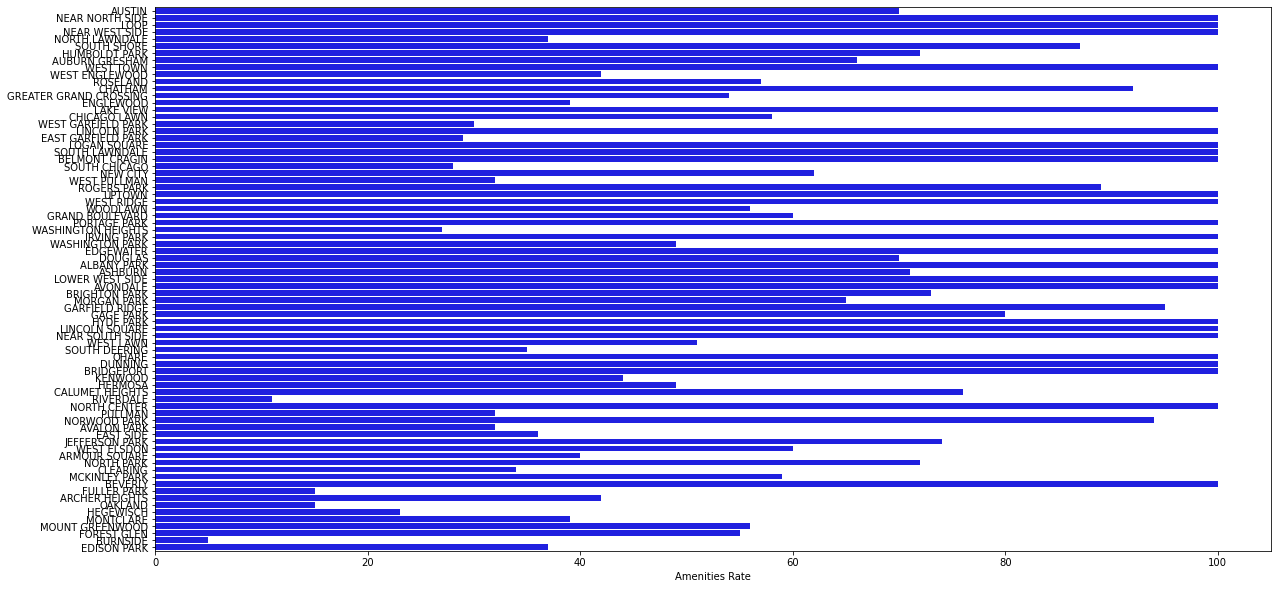

In [41]:
plt.figure(figsize=(20, 10))
sns.barplot(x=grouped_overview['Amenities Rate'],y=grouped_overview.index, orient='h',color='blue')

Nothing stands out of what we expect, so we can proceed

Now let's focus on health/socio-economics factors with the help of this dataset:
https://data.cityofchicago.org/api/views/iqnk-2tcu/rows.csv?accessType=DOWNLOAD

In [42]:
url_health='https://data.cityofchicago.org/api/views/iqnk-2tcu/rows.csv?accessType=DOWNLOAD'
health_stats=pd.read_csv(url_health)

In [43]:
health_stats

Community Area Community Area Name  Birth Rate  General Fertility Rate  \
0                1         Rogers Park        16.4                    62.0   
1                2          West Ridge        17.3                    83.3   
2                3              Uptown        13.1                    50.5   
3                4      Lincoln Square        17.1                    61.0   
4                5        North Center        22.4                    76.2   
..             ...                 ...         ...                     ...   
72              73  Washington Heights        12.0                    61.0   
73              74     Mount Greenwood        12.5                    59.0   
74              75         Morgan Park        13.2                    67.5   
75              76              O'Hare        15.8                    70.0   
76              77           Edgewater        12.1                    48.1   

    Low Birth Weight  Prenatal Care Beginning in First Trimester  \
0               11.0                                        73.0   
1                8.1                                        71.1   
2                8.3                                        77.7   
3                8.1                                        80.5   
4                9.1                                        80.4   
..               ...                                         ...   
72              19.6                                        75.4   
73               8.4                                        94.5   
74              10.6                                        74.5   
75               3.5                                        82.0   
76               7.5                                        76.1   

    Preterm Births  Teen Birth Rate  Assault (Homicide)  \
0             11.2             40.8                 7.7   
1              8.3             29.9                 5.8   
2             10.3             35.1                 5.4   
3              9.7             38.4                 5.0   
4              9.8              8.4                 1.0   
..             ...              ...                 ...   
72            16.2             65.0                38.0   
73            15.1              7.7                 2.2   
74            12.3             46.7                19.9   
75             5.0             15.9                 5.6   
76             7.4             15.1                 5.8   

    Breast cancer in females  ...  Childhood Lead Poisoning  \
0                       23.3  ...                       0.5   
1                       20.2  ...                       1.0   
2                       21.3  ...                       0.5   
3                       21.7  ...                       0.4   
4                       16.6  ...                       0.9   
..                       ...  ...                       ...   
72                      47.9  ...                       1.5   
73                      34.6  ...                       0.0   
74                      32.4  ...                       1.3   
75                      20.5  ...                       0.5   
76                      18.5  ...                       0.9   

    Gonorrhea in Females  Gonorrhea in Males  Tuberculosis  \
0                  322.5               423.3          11.4   
1                  141.0               205.7           8.9   
2                  170.8               468.7          13.6   
3                   98.8               195.5           8.5   
4                   85.4               188.6           1.9   
..                   ...                 ...           ...   
72                1298.2              1274.2           3.0   
73                   NaN                   .           0.0   
74                 800.5               741.1           2.6   
75                   NaN                   .           6.3   
76                 120.1               427.5          10.5   

    Below Poverty Level  Crowded Housin

Time to preprocess the data:

In [44]:
health_stats=health_stats.set_index('Community Area Name')[['Birth Rate','General Fertility Rate','Teen Birth Rate','Cancer (All Sites)','Infant Mortality Rate','Below Poverty Level','Per Capita Income','Unemployment' ]]

In [45]:
health_stats

Birth Rate  General Fertility Rate  Teen Birth Rate  \
Community Area Name                                                        
Rogers Park                16.4                    62.0             40.8   
West Ridge                 17.3                    83.3             29.9   
Uptown                     13.1                    50.5             35.1   
Lincoln Square             17.1                    61.0             38.4   
North Center               22.4                    76.2              8.4   
...                         ...                     ...              ...   
Washington Heights         12.0                    61.0             65.0   
Mount Greenwood            12.5                    59.0              7.7   
Morgan Park                13.2                    67.5             46.7   
O'Hare                     15.8                    70.0             15.9   
Edgewater                  12.1                    48.1             15.1   

                     Cancer (All Sites)  Infant Mortality Rate  \
Community Area Name                                              
Rogers Park                       176.9                    6.4   
West Ridge                        155.9                    5.1   
Uptown                            183.3                    6.5   
Lincoln Square                    153.2                    3.8   
North Center                      152.1                    2.7   
...                                 ...                    ...   
Washington Heights                260.6                   11.2   
Mount Greenwood                   201.1                    3.3   
Morgan Park                       218.2                   13.1   
O'Hare                            138.5                    2.0   
Edgewater                         162.0                    6.9   

                     Below Poverty Level  Per Capita Income  Unemployment  
Community Area Name                                                        
Rogers Park                         22.7              23714           7.5  
West Ridge                          15.1              21375           7.9  
Uptown                              22.7              32355           7.7  
Lincoln Square                       9.5              35503           6.8  
North Center                         7.1              51615           4.5  
...                                  ...                ...           ...  
Washington Heights                  15.7              19709          18.3  
Mount Greenwood                      3.1              34221           6.9  
Morgan Park                         13.7              26185          14.9  
O'Hare                               9.5              29402           4.7  
Edgewater                           16.6              33364           9.0  

[77 rows x 8 columns]

We then normalize our data using min/max scaling 

In [46]:
for column in health_stats.columns:
    health_stats[column]=(health_stats[column]-health_stats[column].min())/(health_stats[column].max()-health_stats[column].min())

In [47]:
health_stats

Birth Rate  General Fertility Rate  Teen Birth Rate  \
Community Area Name                                                        
Rogers Park            0.538462                0.510417         0.341696   
West Ridge             0.607692                0.827381         0.247405   
Uptown                 0.284615                0.339286         0.292388   
Lincoln Square         0.592308                0.495536         0.320934   
North Center           1.000000                0.721726         0.061419   
...                         ...                     ...              ...   
Washington Heights     0.200000                0.495536         0.551038   
Mount Greenwood        0.238462                0.465774         0.055363   
Morgan Park            0.292308                0.592262         0.392734   
O'Hare                 0.492308                0.629464         0.126298   
Edgewater              0.207692                0.303571         0.119377   

                     Cancer (All Sites)  Infant Mortality Rate  \
Community Area Name                                              
Rogers Park                    0.331389               0.232227   
West Ridge                     0.208868               0.170616   
Uptown                         0.368728               0.236967   
Lincoln Square                 0.193116               0.109005   
North Center                   0.186698               0.056872   
...                                 ...                    ...   
Washington Heights             0.819720               0.459716   
Mount Greenwood                0.472579               0.085308   
Morgan Park                    0.572345               0.549763   
O'Hare                         0.107351               0.023697   
Edgewater                      0.244457               0.255924   

                     Below Poverty Level  Per Capita Income  Unemployment  
Community Area Name                                                        
Rogers Park                     0.336192           0.193048      0.092179  
West Ridge                      0.205832           0.163301      0.103352  
Uptown                          0.336192           0.302946      0.097765  
Lincoln Square                  0.109777           0.342982      0.072626  
North Center                    0.068611           0.547896      0.008380  
...                                  ...                ...           ...  
Washington Heights              0.216123           0.142112      0.393855  
Mount Greenwood                 0.000000           0.326678      0.075419  
Morgan Park                     0.181818           0.224475      0.298883  
O'Hare                          0.109777           0.265389      0.013966  
Edgewater                       0.231561           0.315778      0.134078  

[77 rows x 8 columns]

Now, let's keep in mind that 1 doesn't have the same meaning in every case: a score of 1 in per capita income is better than 1 in unemployment, so to invert the scaling, we substract 1 to the "good" or "bad" factors. This is totally arbitrary and is done for the purpose of the analysis

In [48]:
health_stats['Teen Birth Rate']=1-health_stats['Teen Birth Rate']
health_stats['Cancer (All Sites)']=1-health_stats['Cancer (All Sites)']
health_stats['Infant Mortality Rate']=1-health_stats['Infant Mortality Rate']
health_stats['Below Poverty Level']=1-health_stats['Below Poverty Level']
health_stats['Unemployment']=1-health_stats['Unemployment']

Now we can assess a general rate per community area for socio-economic-health factors

In [49]:
health_stats['SEH Rate']=health_stats.sum(axis=1)

In [50]:
health_stats=health_stats.sort_values(by='SEH Rate', ascending=False)
health_stats

Birth Rate  General Fertility Rate  Teen Birth Rate  \
Community Area Name                                                        
North Center           1.000000                0.721726         0.938581   
Near South Side        0.923077                0.672619         0.570934   
O'Hare                 0.492308                0.629464         0.873702   
Lincoln Park           0.292308                0.163690         0.993080   
Lake View              0.315385                0.163690         0.874567   
...                         ...                     ...              ...   
Douglas                0.069231                0.215774         0.715398   
Washington Park        0.761538                0.660714         0.296713   
West Garfield Park     0.823077                0.903274         0.017301   
Riverdale              0.238462                0.273810         0.453287   
Fuller Park            0.192308                0.486607         0.412630   

                     Cancer (All Sites)  Infant Mortality Rate  \
Community Area Name                                              
North Center                   0.813302               0.943128   
Near South Side                0.714702               0.843602   
O'Hare                         0.892649               0.976303   
Lincoln Park                   0.808635               0.957346   
Lake View                      0.960327               0.966825   
...                                 ...                    ...   
Douglas                        0.126021               0.436019   
Washington Park                0.195449               0.156398   
West Garfield Park             0.000000               0.170616   
Riverdale                      0.193699               0.658768   
Fuller Park                    0.190198               0.000000   

                     Below Poverty Level  Per Capita Income  Unemployment  \
Community Area Name                                                         
North Center                    0.931389           0.547896      0.991620   
Near South Side                 0.862779           0.662080      0.958101   
O'Hare                          0.890223           0.265389      0.986034   
Lincoln Park                    0.850772           0.799562      0.991620   
Lake View                       0.873070           0.631989      0.986034   
...                                  ...                ...           ...   
Douglas                         0.605489           0.185214      0.650838   
Washington Park                 0.382504           0.057893      0.469274   
West Garfield Park              0.361921           0.030727      0.413408   
Riverdale                       0.000000           0.000000      0.379888   
Fuller Park                     0.101201           0.006117      0.000000   

                     SEH Rate  
Community Area Name            
North Center         6.887644  
Near South Side      6.207894  
O'Hare               6.006072  
Lincoln Park         5.857013  
Lake View            5.771886  
...                       ...  
Douglas              3.003983  
Washington Park      2.980484  
West Garfield Park   2.720324  
Riverdale            2.197913  
Fuller Park          1.389061  

[77 rows x 9 columns]

Now let's try to merge our 3 critiria in one database: -Crime Rate, - Amenity Rate, - SEH Rate

In [51]:
ktab=percan['TOTAL'].to_frame().rename(columns={'TOTAL':'Crime Rate'})

In [52]:
ktab

Crime Rate
AUSTIN                 5.67
NEAR NORTH SIDE        4.87
LOOP                   4.05
NEAR WEST SIDE         3.51
NORTH LAWNDALE         3.51
...                     ...
MONTCLARE              0.22
MOUNT GREENWOOD        0.21
FOREST GLEN            0.18
BURNSIDE               0.14
EDISON PARK            0.09

[77 rows x 1 columns]

The value are in percent and not scaled, so let's scale them using min/max too.

In [53]:
ktab['Crime Rate']=(ktab['Crime Rate']-ktab['Crime Rate'].min())/(ktab['Crime Rate'].max()-ktab['Crime Rate'].min())

In [54]:
ktab

Crime Rate
AUSTIN             1.000000
NEAR NORTH SIDE    0.856631
LOOP               0.709677
NEAR WEST SIDE     0.612903
NORTH LAWNDALE     0.612903
...                     ...
MONTCLARE          0.023297
MOUNT GREENWOOD    0.021505
FOREST GLEN        0.016129
BURNSIDE           0.008961
EDISON PARK        0.000000

[77 rows x 1 columns]

We check that the index is the same between the two df that we want concat

In [55]:
(ktab.index==grouped_overview.index).sum()

77

77 True, so the indexes are identicals, we can concat the values of amenities rate

In [56]:
ktab['Amenity Rate']=grouped_overview['Amenities Rate']

In [57]:
ktab['Amenity Rate']=(ktab['Amenity Rate']-ktab['Amenity Rate'].min())/(ktab['Amenity Rate'].max()-ktab['Amenity Rate'].min())

In [58]:
ktab

Crime Rate  Amenity Rate
AUSTIN             1.000000      0.684211
NEAR NORTH SIDE    0.856631      1.000000
LOOP               0.709677      1.000000
NEAR WEST SIDE     0.612903      1.000000
NORTH LAWNDALE     0.612903      0.336842
...                     ...           ...
MONTCLARE          0.023297      0.357895
MOUNT GREENWOOD    0.021505      0.536842
FOREST GLEN        0.016129      0.526316
BURNSIDE           0.008961      0.000000
EDISON PARK        0.000000      0.336842

[77 rows x 2 columns]

We do the same for the SEH rate

In [59]:
health_stats.index=health_stats.index.str.upper()

In [60]:
for row in ktab.index:
    if row in (health_stats.index):
        None
    else:
        print(row, 'is not in ktab')

OHARE is not in ktab
MONTCLARE is not in ktab


We see that two indexes are different. For OHARE, we can suppose that it is written O'hare

In [61]:
as_list3 = health_stats.index.tolist()
idx3 = as_list3.index("O'HARE")
as_list3[idx3] = 'OHARE'
health_stats.index = as_list3

We now check MONTCLARE

In [62]:
health_stats[health_stats.index.str.contains('MONT')]

Birth Rate  General Fertility Rate  Teen Birth Rate  \
MONTCLAIRE        0.592308                0.830357         0.479239   
BELMONT CRAGIN    0.815385                0.906250         0.421280   

                Cancer (All Sites)  Infant Mortality Rate  \
MONTCLAIRE                0.819720               0.853081   
BELMONT CRAGIN            0.810385               0.805687   

                Below Poverty Level  Per Capita Income  Unemployment  SEH Rate  
MONTCLAIRE                 0.833619           0.161800      0.815642  5.385766  
BELMONT CRAGIN             0.734134           0.085351      0.796089  5.374562

In [63]:
as_list4 = health_stats.index.tolist()
idx4 = as_list4.index("MONTCLAIRE")
as_list4[idx4] = 'MONTCLARE'
health_stats.index = as_list4

In [64]:
for row in ktab.index:
    if row in (health_stats.index):
        None
    else:
        print(row, 'is not in ktab')

We have rerunned the check loop, and we can see that now the indexes match

In [65]:
ktab['SEH Rate']=(health_stats['SEH Rate']-health_stats['SEH Rate'].min())/(health_stats['SEH Rate'].max()-health_stats['SEH Rate'].min())

In [66]:
ktab

Crime Rate  Amenity Rate  SEH Rate
AUSTIN             1.000000      0.684211  0.397198
NEAR NORTH SIDE    0.856631      1.000000  0.723216
LOOP               0.709677      1.000000  0.732392
NEAR WEST SIDE     0.612903      1.000000  0.632709
NORTH LAWNDALE     0.612903      0.336842  0.369960
...                     ...           ...       ...
MONTCLARE          0.023297      0.357895  0.726861
MOUNT GREENWOOD    0.021505      0.536842  0.718946
FOREST GLEN        0.016129      0.526316  0.767015
BURNSIDE           0.008961      0.000000  0.377331
EDISON PARK        0.000000      0.336842  0.711122

[77 rows x 3 columns]

Now let's try to apply K means clustering.

In [67]:
X=ktab.values

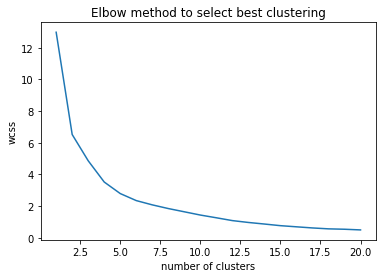

In [68]:
wcss = []
for i in range(1, 21): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 20, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,21), wcss)
plt.title("Elbow method to select best clustering")
plt.xlabel("number of clusters")
plt.ylabel("wcss")
plt.show()

Here using the elbow method, we can say that 5 is the optimal k number

In [69]:
kmeans = KMeans(n_clusters = 5, max_iter = 300, init = 'k-means++', n_init = 20, random_state = 0)
y_kmeans = kmeans.fit_predict(X)
y_kmeans

array([3, 3, 3, 3, 0, 3, 3, 0, 1, 0, 0, 3, 0, 0, 1, 2, 0, 1, 0, 1, 1, 1,
       0, 2, 0, 1, 1, 1, 0, 0, 1, 4, 1, 0, 1, 0, 1, 2, 1, 1, 2, 2, 1, 1,
       1, 1, 1, 2, 4, 1, 1, 1, 2, 2, 2, 4, 1, 4, 1, 4, 2, 2, 2, 2, 2, 2,
       2, 1, 4, 2, 4, 4, 2, 2, 2, 4, 2])

<IPython.core.display.Javascript object>


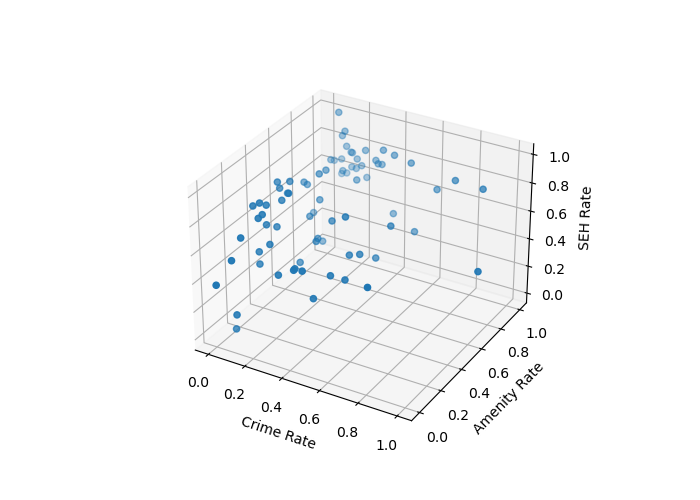

Text(0.5, 0, 'SEH Rate')

In [70]:
%matplotlib notebook
plt.figure('ktab', figsize=(7,5))
ax = plt.axes(projection = '3d')
ax.scatter(X[:,0],X[:,1],X[:,2]);
ax.set_xlabel('Crime Rate',rotation=150)
ax.set_ylabel('Amenity Rate')
ax.set_zlabel('SEH Rate',rotation=60)



In [71]:
centroids = kmeans.cluster_centers_

<IPython.core.display.Javascript object>


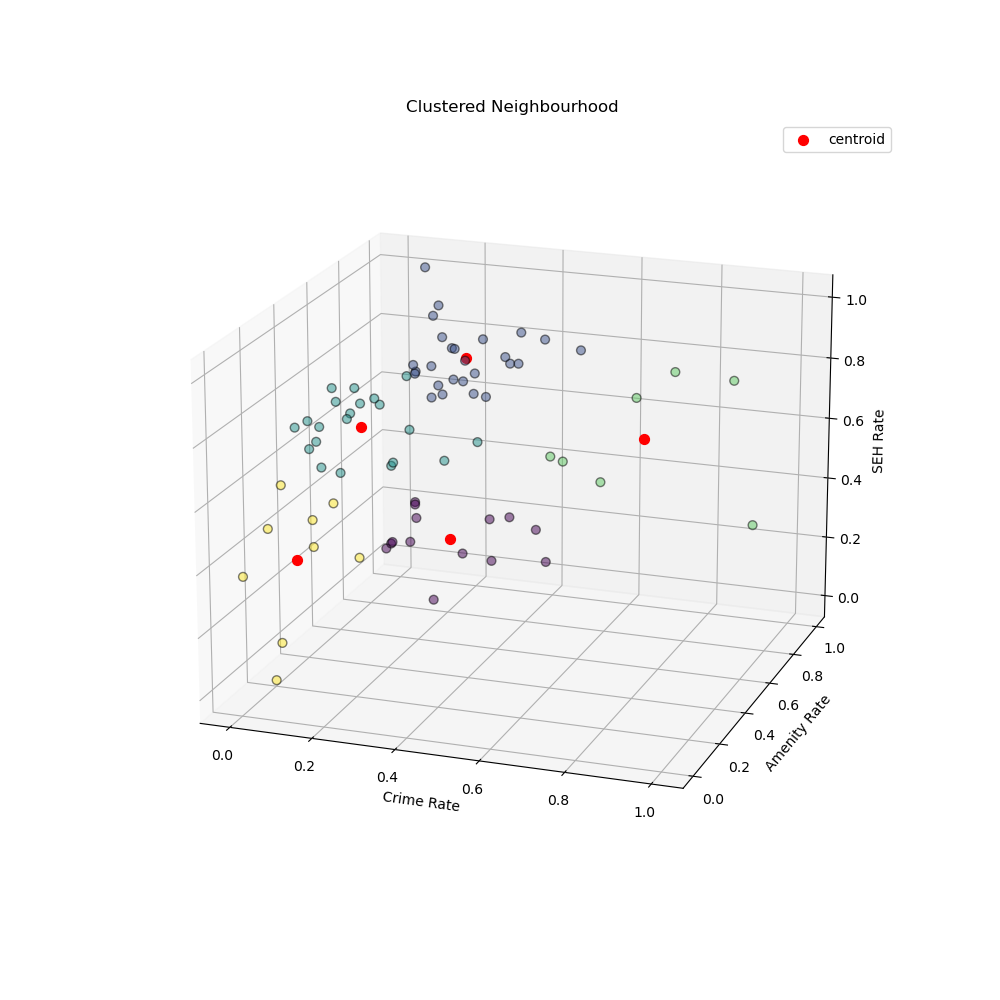

In [72]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2], 
            c=y_kmeans, cmap='viridis',
            edgecolor='k', s=40, alpha = 0.5)


ax.set_title("Clustered Neighbourhood")
ax.set_xlabel("Crime Rate")
ax.set_ylabel("Amenity Rate")
ax.set_zlabel("SEH Rate")
ax.dist = 10

# plot centroids

ax.scatter(centroids[0,0],centroids[0,1],centroids[0,2] ,c='r', s=50, label='centroid')
ax.scatter(centroids[1,0],centroids[1,1],centroids[1,2] ,c='r', s=50)
ax.scatter(centroids[2,0],centroids[2,1],centroids[2,2] ,c='r', s=50)
ax.scatter(centroids[3,0],centroids[3,1],centroids[3,2] ,c='r', s=50)
ax.scatter(centroids[4,0],centroids[4,1],centroids[4,2] ,c='r', s=50)

ax.legend()



In [73]:
ktab['Cluster']=y_kmeans

In [74]:
ktab

Crime Rate  Amenity Rate  SEH Rate  Cluster
AUSTIN             1.000000      0.684211  0.397198        3
NEAR NORTH SIDE    0.856631      1.000000  0.723216        3
LOOP               0.709677      1.000000  0.732392        3
NEAR WEST SIDE     0.612903      1.000000  0.632709        3
NORTH LAWNDALE     0.612903      0.336842  0.369960        0
...                     ...           ...       ...      ...
MONTCLARE          0.023297      0.357895  0.726861        2
MOUNT GREENWOOD    0.021505      0.536842  0.718946        2
FOREST GLEN        0.016129      0.526316  0.767015        2
BURNSIDE           0.008961      0.000000  0.377331        4
EDISON PARK        0.000000      0.336842  0.711122        2

[77 rows x 4 columns]

We see here that we have 5 different clusters. So let's try to find what bound the points in the cluster together.

In [75]:
ktab[ktab.Cluster==0]

Crime Rate  Amenity Rate  SEH Rate  Cluster
NORTH LAWNDALE            0.612903      0.336842  0.369960        0
AUBURN GRESHAM            0.482079      0.642105  0.320611        0
WEST ENGLEWOOD            0.462366      0.389474  0.326521        0
ROSELAND                  0.449821      0.547368  0.398061        0
GREATER GRAND CROSSING    0.412186      0.515789  0.399293        0
ENGLEWOOD                 0.403226      0.357895  0.355040        0
WEST GARFIELD PARK        0.367384      0.263158  0.242110        0
EAST GARFIELD PARK        0.315412      0.252632  0.425576        0
SOUTH CHICAGO             0.275986      0.242105  0.423360        0
WEST PULLMAN              0.256272      0.284211  0.397083        0
WOODLAWN                  0.218638      0.536842  0.409870        0
GRAND BOULEVARD           0.202509      0.578947  0.397419        0
WASHINGTON PARK           0.173835      0.463158  0.289424        0
DOUGLAS                   0.164875      0.684211  0.293698        0

Cluster 0 is comprised of Average and low Crime Rate, Amenity Rate and SEH Rate.

In [76]:
ktab[ktab.Cluster==1]

Crime Rate  Amenity Rate  SEH Rate  Cluster
WEST TOWN          0.471326      1.000000  0.773020        1
LAKE VIEW          0.379928      1.000000  0.797083        1
LINCOLN PARK       0.318996      1.000000  0.812564        1
LOGAN SQUARE       0.311828      1.000000  0.706920        1
SOUTH LAWNDALE     0.290323      1.000000  0.704243        1
BELMONT CRAGIN     0.277778      1.000000  0.724823        1
ROGERS PARK        0.238351      0.884211  0.640016        1
UPTOWN             0.227599      1.000000  0.583013        1
WEST RIDGE         0.220430      1.000000  0.777153        1
PORTAGE PARK       0.198925      1.000000  0.658743        1
IRVING PARK        0.173835      1.000000  0.698676        1
EDGEWATER          0.168459      1.000000  0.627904        1
ALBANY PARK        0.146953      1.000000  0.734974        1
LOWER WEST SIDE    0.143369      1.000000  0.630634        1
AVONDALE           0.139785      1.000000  0.736652        1
GARFIELD RIDGE     0.123656      0.947368  0.628112        1
GAGE PARK          0.123656      0.789474  0.728314        1
HYDE PARK          0.114695      1.000000  0.575905        1
LINCOLN SQUARE     0.114695      1.000000  0.770436        1
NEAR SOUTH SIDE    0.105735      1.000000  0.876377        1
OHARE              0.091398      1.000000  0.839673        1
DUNNING            0.086022      1.000000  0.668504        1
BRIDGEPORT         0.086022      1.000000  0.561548        1
NORTH CENTER       0.071685      1.000000  1.000000        1
NORWOOD PARK       0.062724      0.936842  0.693322        1
BEVERLY            0.044803      1.000000  0.644411        1

Cluster 1 is comprised of Average to very low Crime Rate, High Amenity Rate and High SEH Rate

In [77]:
ktab[ktab.Cluster==2]

Crime Rate  Amenity Rate  SEH Rate  Cluster
CHICAGO LAWN       0.367384      0.557895  0.627607        2
NEW CITY           0.268817      0.600000  0.535169        2
ASHBURN            0.145161      0.694737  0.581548        2
BRIGHTON PARK      0.130824      0.715789  0.749180        2
MORGAN PARK        0.127240      0.631579  0.495481        2
WEST LAWN          0.103943      0.484211  0.745243        2
KENWOOD            0.082437      0.410526  0.546181        2
HERMOSA            0.078853      0.463158  0.699800        2
CALUMET HEIGHTS    0.077061      0.747368  0.429901        2
EAST SIDE          0.057348      0.326316  0.677891        2
JEFFERSON PARK     0.057348      0.726316  0.640421        2
WEST ELSDON        0.051971      0.578947  0.751688        2
ARMOUR SQUARE      0.051971      0.368421  0.576640        2
NORTH PARK         0.051971      0.705263  0.668448        2
CLEARING           0.048387      0.305263  0.661555        2
MCKINLEY PARK      0.044803      0.568421  0.671773        2
ARCHER HEIGHTS     0.039427      0.389474  0.697873        2
MONTCLARE          0.023297      0.357895  0.726861        2
MOUNT GREENWOOD    0.021505      0.536842  0.718946        2
FOREST GLEN        0.016129      0.526316  0.767015        2
EDISON PARK        0.000000      0.336842  0.711122        2

Cluster 2 is comprised of very low crime rate Average Amenity Rate and Average SEH

In [78]:
ktab[ktab.Cluster==3]

Crime Rate  Amenity Rate  SEH Rate  Cluster
AUSTIN             1.000000      0.684211  0.397198        3
NEAR NORTH SIDE    0.856631      1.000000  0.723216        3
LOOP               0.709677      1.000000  0.732392        3
NEAR WEST SIDE     0.612903      1.000000  0.632709        3
SOUTH SHORE        0.568100      0.863158  0.398651        3
HUMBOLDT PARK      0.526882      0.705263  0.526692        3
CHATHAM            0.422939      0.915789  0.442097        3

Cluster 3 is comprised of High-Average Crime Rate, High Amenity Rate and Average Seh Rate

In [79]:
ktab[ktab.Cluster==4]

Crime Rate  Amenity Rate  SEH Rate  Cluster
WASHINGTON HEIGHTS    0.198925      0.231579  0.365210        4
SOUTH DEERING         0.102151      0.315789  0.489898        4
RIVERDALE             0.075269      0.063158  0.147102        4
PULLMAN               0.064516      0.284211  0.355941        4
AVALON PARK           0.062724      0.284211  0.443233        4
FULLER PARK           0.041219      0.105263  0.000000        4
OAKLAND               0.026882      0.105263  0.486479        4
HEGEWISCH             0.025090      0.189474  0.590016        4
BURNSIDE              0.008961      0.000000  0.377331        4

For the Cluster 4, We see that it is a combination of Low Crime Rate, Low Amenity Rate and Low-Average SEH Rate

We will label these different clusters now
- 0 is Average
- 1 is Very Good
- 2 is Good
- 3 is Not very Good
- 4 is Nothing to see here

In [80]:
cluster_label=[]
for row in ktab.index:
    if ktab['Cluster'][row]==0:
        cluster_label.append('Average')
    elif ktab['Cluster'][row]==1:
        cluster_label.append('Very Good')
    elif ktab['Cluster'][row]==2:
        cluster_label.append('Good')
    elif ktab['Cluster'][row]==3:
        cluster_label.append('Not very Good')
    else:
        cluster_label.append('Nothing to see here')
    

In [81]:
ktab['Cluster Label']=cluster_label

In [82]:
ktab

Crime Rate  Amenity Rate  SEH Rate  Cluster  \
AUSTIN             1.000000      0.684211  0.397198        3   
NEAR NORTH SIDE    0.856631      1.000000  0.723216        3   
LOOP               0.709677      1.000000  0.732392        3   
NEAR WEST SIDE     0.612903      1.000000  0.632709        3   
NORTH LAWNDALE     0.612903      0.336842  0.369960        0   
...                     ...           ...       ...      ...   
MONTCLARE          0.023297      0.357895  0.726861        2   
MOUNT GREENWOOD    0.021505      0.536842  0.718946        2   
FOREST GLEN        0.016129      0.526316  0.767015        2   
BURNSIDE           0.008961      0.000000  0.377331        4   
EDISON PARK        0.000000      0.336842  0.711122        2   

                       Cluster Label  
AUSTIN                 Not very Good  
NEAR NORTH SIDE        Not very Good  
LOOP                   Not very Good  
NEAR WEST SIDE         Not very Good  
NORTH LAWNDALE               Average  
...                              ...  
MONTCLARE                       Good  
MOUNT GREENWOOD                 Good  
FOREST GLEN                     Good  
BURNSIDE         Nothing to see here  
EDISON PARK                     Good  

[77 rows x 5 columns]

Now we can display on a map the different community areas, with their color corresponding to their label

In [83]:
tooltip_text1 = []
for f in range(len(ktab)):
    tooltip_text1.append(str(ktab['Cluster Label'][f]))
tooltip_text1# Append a tooltip column with customised text

#we want to be sure that the data we append fit the right name. Thus we check first that the names match before.
#we do that for every row of our df (0 to 76)
i=0
while i!= len(percan):
    for idx in range(len(percan)):
        if map_data['features'][idx]['properties']['community']==ktab.index[i]:
            map_data['features'][idx]['properties']['tooltip2'] = tooltip_text1[i]
        else:
            None
    i=i+1  

In [84]:
CHI_map_cluster=folium.Map(location=[lat,lng], zoom_start=10)

choropleth1 =folium.Choropleth(
    geo_data=map_data,
    name="choropleth",
    data=ktab,
    columns=[percan.index,"Cluster"],
    key_on='feature.properties.community',
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Clustered Community Area",
    highlight=True,
    show=True,
).add_to(CHI_map_cluster)

choropleth1.geojson.add_child(folium.features.GeoJsonTooltip(
        fields=['community','tooltip2'],
        aliases=['Community Name', 'Classification'],
        style=('background-color: white; color: black;')
        )
)


CHI_map_cluster

With this map, we can see what community area belongs to what cluster. We see that the very good areas are in general to the north of Chicago.